In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images it returns images in BGR, no RGB
images = glob.glob('camera_cal\*.jpg')
print (images)

['camera_cal\\calibration1.jpg', 'camera_cal\\calibration10.jpg', 'camera_cal\\calibration11.jpg', 'camera_cal\\calibration12.jpg', 'camera_cal\\calibration13.jpg', 'camera_cal\\calibration14.jpg', 'camera_cal\\calibration15.jpg', 'camera_cal\\calibration16.jpg', 'camera_cal\\calibration17.jpg', 'camera_cal\\calibration18.jpg', 'camera_cal\\calibration19.jpg', 'camera_cal\\calibration2.jpg', 'camera_cal\\calibration20.jpg', 'camera_cal\\calibration3.jpg', 'camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg', 'camera_cal\\calibration6.jpg', 'camera_cal\\calibration7.jpg', 'camera_cal\\calibration8.jpg', 'camera_cal\\calibration9.jpg']


In [2]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imshow('img', img)
    cv2.waitKey(500)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    print (ret)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True


camera_cal\calibration9.jpg


Text(0.5,1,'Undistorted Image')

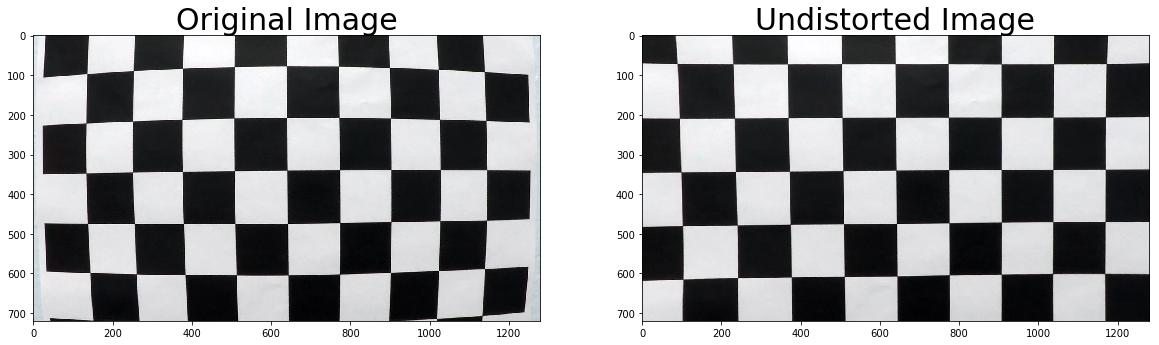

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
print (fname)
img = cv2.imread('camera_cal\calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal\wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [1]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [2]:
def distortion_correction(img, mtx, dist):
    img_size = (img.shape[1],img.shape[0])
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    src = np.float32([[567,460],[725,460],[215,670],[1125,670]])
    #src = np.float32([[582,460],[730,460],[215,670],[1115,670]])
    posx = 50
    posy = 50
    
    dstn = np.float32([[posx,posy],[img.shape[1] - posx, posy],[posx, img.shape[0]],\
                       [img.shape[1] - posx, img.shape[0]]])
    
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dstn)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M

In [3]:
def colorGrad_pipeline(img, s_thresh=(170, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=15) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 20) & (h_channel <= 30)] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary2 = np.dstack(( np.zeros_like(sxbinary), sxbinary, h_binary)) * 255
    binary = np.zeros_like(s_channel)
    
    binary[(s_binary == 1) | (sxbinary == 1)] = 1
    plt.imshow(binary)
    
    return binary

In [4]:
def find_lane_pixels(binary_warped, margin = 100):
    
    global right_line
    global left_line
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    left_line.line_base_pos = leftx_base
    right_line.line_base_pos = rightx_base

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [5]:
def search_around_poly (binary_warped, margin = 100):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [27]:
def fit_poly(img_shape, leftx, lefty, rightx, righty, valor):
    
    global right_line
    global left_line
    
    n = 5
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #be sure they are good detection
    if len(left_line.recent_xfitted) > 1:
        diff_left = (left_fit - left_line.current_fit) / left_line.current_fit
        if diff_left.all() < valor :
            left_line.detected = True
        else:
            left_line.detected = False
    else:
        left_line.detected = True
    if len(right_line.recent_xfitted) > 1:     
        diff_right = (right_fit - right_line.current_fit) / right_line.current_fit
        if diff_right.all() < valor :
            right_line.detected = True
        else:
            right_line.detected = False
    else:
        right_line.detected = True
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
    
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty
    right_line.detected = True
    left_line.detected = True
    
    if left_line.detected:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]  
        left_line.current_fit = left_fit
        
        left_line.recent_xfitted.append(left_fitx)
        
#         while len(left_line.recent_xfitted) > n :
#             left_line.recent_xfitted = np.delete(left_line.recent_xfitted, n, 1)
#             #left_line.recent_xfitted = left_line.recent_xfitted [0:n-1]
        
#         sum=left_fitx*0
#         for i in range(0, len(left_line.recent_xfitted)):
#             sum += left_line.recent_xfitted[i]
#         left_line.bestx = sum / len(left_line.recent_xfitted)
        
#         left_line.best_fit = np.polyfit(ploty, left_line.bestx, 2)
        
    if right_line.detected:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_line.current_fit = right_fit
        
        right_line.recent_xfitted.append(right_fitx)
        
#         while len(right_line.recent_xfitted) > n :
#             right_line.recent_xfitted = np.delete(right_line.recent_xfitted, n, 1)
#             #left_line.recent_xfitted = left_line.recent_xfitted [0:n-1]
        
#         sum=right_fitx*0
#         for i in range(0, len(right_line.recent_xfitted)):
#             sum += right_line.recent_xfitted[i]
#         right_line.bestx = sum / len(right_line.recent_xfitted)
        
#         right_line.best_fit = np.polyfit(ploty, right_line.bestx, 2)
        
    return left_fitx, right_fitx, ploty 
        

In [7]:
def visualization(binary_warped , wraped, left_fitx, right_fitx, ploty, margin):
    
    #left_fitx = left_line.bestx
    #right_fitx = right_line.bestx
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(wraped, 1, window_img, 0.3, 0)
    
    return result, window_img
    

In [25]:
def find_lane(binary_warped , wraped):
    
    global right_line
    global left_line
    
    margin = 100
    valor = 10
    if not(left_line.detected) or not(right_line.detected) :
        # Find our lane pixels first
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped, margin)
    else:
        leftx, lefty, rightx, righty = search_around_poly(binary_warped, margin)
    
    left_fitx1, right_fitx1, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty,valor)
    
    out_img = visualization(binary_warped , wraped , left_fitx1, right_fitx1, ploty, 25)

    # Plots the left and right polynomials on the lane lines

    return out_img

In [9]:
import numpy as np
from numpy.linalg import inv
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpim
%matplotlib inline

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

left_line = Line()
right_line = Line()

False


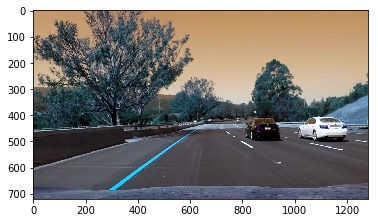

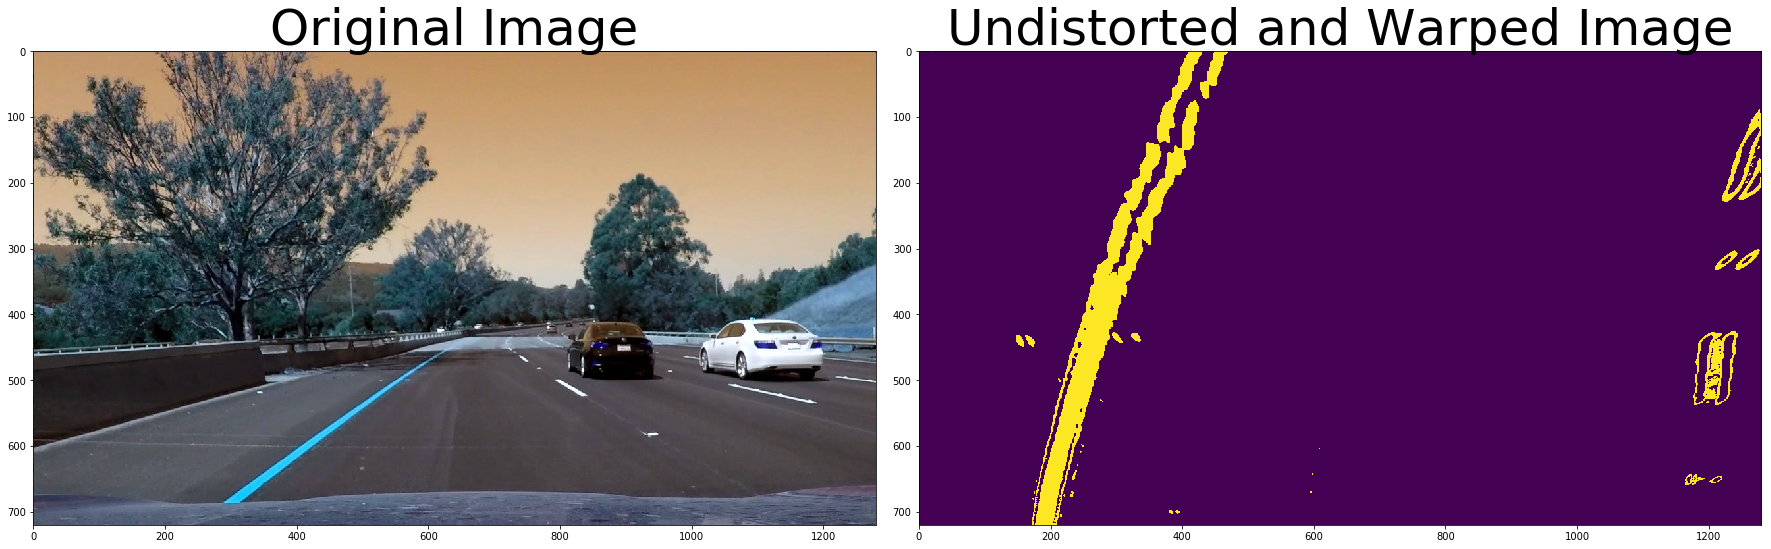

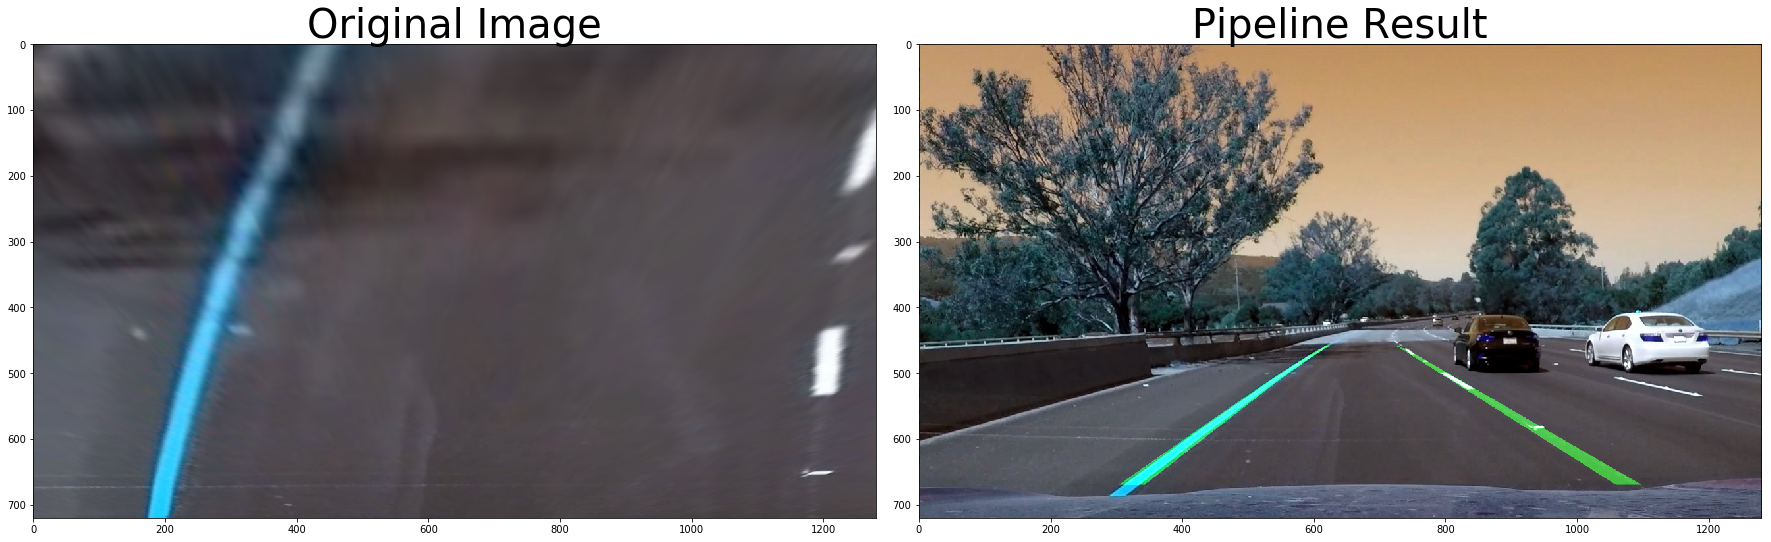

In [10]:
img2 = cv2.imread('test_images/test6.jpg')
#image = cv2.imread('test_images/straight_lines1.jpg')
plt.imshow(img2)

wraped, M = distortion_correction(img2, mtx, dist)
Minv = inv(M)
                               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(wraped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

result = colorGrad_pipeline(wraped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(wraped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

result, window_img = find_lane(result , wraped)

new_window_img = cv2.warpPerspective(window_img, Minv, (img2.shape[1], img2.shape[0]))

out_img = cv2.addWeighted(img2, 1, new_window_img, 0.5, 0)

plt.imshow(out_img)

Fit poly para los dos, uno solo, que funcione todo junto, ternimar de llenar los cosos, mejor leer todos las madres

In [12]:
import numpy as np
from numpy.linalg import inv
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpim
%matplotlib inline

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


In [13]:
def pipeline(image):

    wraped, M = distortion_correction(image, mtx, dist)
    Minv = inv(M)
    result = colorGrad_pipeline(wraped)
    result1, window_img = find_lane(result , wraped)
    new_window_img = cv2.warpPerspective(window_img, Minv, (img2.shape[1], img2.shape[0]))
    out_img = cv2.addWeighted(image, 1, new_window_img, 0.5, 0)

    return out_img

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4



 12%|█▏        | 152/1261 [00:44<05:45,  3.21it/s]


 24%|██▍       | 303/1261 [01:30<04:54,  3.26it/s]


 36%|███▌      | 454/1261 [02:18<04:05,  3.29it/s]


 48%|████▊     | 605/1261 [03:06<03:41,  2.96it/s]


 60%|█████▉    | 756/1261 [03:54<02:30,  3.37it/s]


 72%|███████▏  | 907/1261 [04:38<01:45,  3.37it/s]


 84%|████████▍ | 1057/1261 [05:25<01:08,  2.96it/s]


 96%|█████████▌| 1205/1261 [06:13<00:17,  3.27it/s]


100%|█████████▉| 1260/1261 [06:31<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 4min 1s, sys: 20.6 s, total: 4min 22s
Wall time: 6min 34s


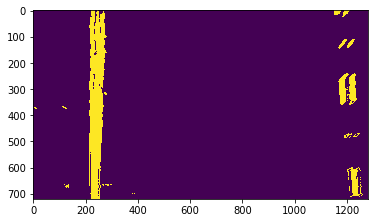

In [30]:
output_video = 'output_video.mp4'
left_line = Line()
right_line = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output_video, audio=False)

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))